# Symbolic Regression with Diffusion Models: Synthetic Dataset Evaluation and Model Comparison



# Block 1: Generate Synthetic Scientific Data


In [3]:

import numpy as np
import pandas as pd

# Define ranges for variables
np.random.seed(42)  # For reproducibility
n_samples = 1000  # Number of data points

# Generate variables
x1 = np.random.uniform(-10, 10, n_samples)
x2 = np.random.uniform(1, 20, n_samples)
x3 = np.random.uniform(0.1, 5, n_samples)

# Define scientific equations
# y1 = Newton's second law: F = m * a
y1 = x1 * x2  # x1 -> mass (m), x2 -> acceleration (a)

# y2 = Gravitational force: F = G * (m1 * m2) / r^2
G = 6.67430e-11  # Gravitational constant
y2 = G * ((x1 * x2) / (x3**2))  # x3 -> distance (r)

# y3 = Energy of a photon: E = h * f
h = 6.626e-34  # Planck's constant
y3 = h * x2  # x2 -> frequency (f)

# Add noise to outputs
y1 += np.random.normal(0, 0.1, n_samples)
y2 += np.random.normal(0, 1e-12, n_samples)
y3 += np.random.normal(0, 1e-34, n_samples)

# Combine into a DataFrame
data = pd.DataFrame({
    'x1_mass': x1,
    'x2_acceleration': x2,
    'x3_distance': x3,
    'y1_force': y1,
    'y2_gravitational_force': y2,
    'y3_photon_energy': y3
})

# Save the dataset
data.to_csv('synthetic_scientific_data.csv', index=False)
print("Synthetic scientific dataset created and saved as 'synthetic_scientific_data.csv'.")

# Preview the dataset
print(data.head())


Synthetic scientific dataset created and saved as 'synthetic_scientific_data.csv'.
    x1_mass  x2_acceleration  x3_distance    y1_force  y2_gravitational_force  \
0 -2.509198         4.517526     1.382358  -11.229371           -3.964328e-10   
1  9.014286        11.296118     1.310196  101.888140            3.958734e-09   
2  4.639879        17.585971     4.540647   81.665131            2.645738e-10   
3  1.973170        14.912273     1.322776   29.287849            1.122460e-09   
4 -6.879627        16.324662     1.432554 -112.186393           -3.653117e-09   

   y3_photon_energy  
0      2.789690e-33  
1      7.489557e-33  
2      1.162756e-32  
3      9.713583e-33  
4      1.085714e-32  


# Block 2: Data Preprocessing


In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('synthetic_scientific_data.csv')
print("Dataset loaded successfully!")

# Normalize the input variables (x1, x2, x3) and target variables (y1, y2, y3)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

# Split the dataset into training, validation, and test sets (80/10/10 split)
train_data, temp_data = train_test_split(normalized_df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Save the splits for later use
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Data has been split and saved:")
print(f"Training Set: {train_data.shape}")
print(f"Validation Set: {val_data.shape}")
print(f"Test Set: {test_data.shape}")

# Preview the training data
print("Training Data Preview:")
print(train_data.head())


Dataset loaded successfully!
Data has been split and saved:
Training Set: (800, 6)
Validation Set: (100, 6)
Test Set: (100, 6)
Training Data Preview:
      x1_mass  x2_acceleration  x3_distance  y1_force  y2_gravitational_force  \
29   0.042025         0.828851     0.655599  0.100477                0.633108   
535  0.944777         0.119121     0.835964  0.583780                0.634114   
695  0.608981         0.065202     0.520160  0.518295                0.634051   
557  0.024270         0.409368     0.300212  0.283749                0.631827   
836  0.914709         0.125354     0.995424  0.580915                0.634081   

     y3_photon_energy  
29       1.043115e-32  
535      1.560310e-33  
695      1.038611e-33  
557      5.132507e-33  
836      1.649009e-33  


# Block 3: Diffusion Model Design and Training Preparation


In [5]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Define the Dataset Class
class ScientificDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.inputs = data.iloc[:, :-3].values  # Select input columns (x1, x2, x3)
        self.targets = data.iloc[:, -3:].values  # Select target columns (y1, y2, y3)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

# Load the training, validation, and test data
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

train_dataset = ScientificDataset(train_data)
val_dataset = ScientificDataset(val_data)
test_dataset = ScientificDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Diffusion Model Architecture
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, noise_level):
        # Apply Gaussian noise based on noise_level
        noise = torch.randn_like(x) * noise_level
        x_noisy = x + noise

        # Encode and decode
        encoded = self.encoder(x_noisy)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the Diffusion Model
input_dim = train_dataset.inputs.shape[1]  # Number of input features (e.g., x1, x2, x3)
output_dim = train_dataset.targets.shape[1]  # Number of target features (e.g., y1, y2, y3)

model = DiffusionModel(input_dim=input_dim, output_dim=output_dim)
print(model)

# Define noise schedule
def noise_schedule(t, T):
    return (1 - t / T) ** 2  # Example schedule (quadratic decay)

# Example usage of noise schedule
T = 1000  # Total timesteps
example_noise_levels = [noise_schedule(t, T) for t in range(T)]

# Save model structure
torch.save(model.state_dict(), 'diffusion_model.pth')


DiffusionModel(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)


# Block 4: Training the Diffusion Model


In [6]:

import torch.optim as optim

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop parameters
epochs = 50
T = 1000  # Total diffusion steps

# Function to add noise
def add_noise(inputs, noise_level):
    noise = torch.randn_like(inputs) * noise_level
    return inputs + noise

# Training loop
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Add noise to inputs based on the current noise level
        noise_level = noise_schedule(epoch, epochs)
        noisy_inputs = add_noise(inputs, noise_level)

        # Forward pass
        outputs = model(noisy_inputs, noise_level)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            noise_level = noise_schedule(epoch, epochs)
            noisy_inputs = add_noise(inputs, noise_level)

            outputs = model(noisy_inputs, noise_level)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_diffusion_model.pth')
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

print("Training complete.")


Epoch 1/50, Train Loss: 0.0570, Val Loss: 0.0203
Best model saved with validation loss: 0.0203
Epoch 2/50, Train Loss: 0.0212, Val Loss: 0.0168
Best model saved with validation loss: 0.0168
Epoch 3/50, Train Loss: 0.0162, Val Loss: 0.0138
Best model saved with validation loss: 0.0138
Epoch 4/50, Train Loss: 0.0134, Val Loss: 0.0121
Best model saved with validation loss: 0.0121
Epoch 5/50, Train Loss: 0.0129, Val Loss: 0.0126
Epoch 6/50, Train Loss: 0.0123, Val Loss: 0.0123
Epoch 7/50, Train Loss: 0.0121, Val Loss: 0.0135
Epoch 8/50, Train Loss: 0.0121, Val Loss: 0.0117
Best model saved with validation loss: 0.0117
Epoch 9/50, Train Loss: 0.0120, Val Loss: 0.0126
Epoch 10/50, Train Loss: 0.0125, Val Loss: 0.0119
Epoch 11/50, Train Loss: 0.0121, Val Loss: 0.0128
Epoch 12/50, Train Loss: 0.0117, Val Loss: 0.0122
Epoch 13/50, Train Loss: 0.0119, Val Loss: 0.0128
Epoch 14/50, Train Loss: 0.0112, Val Loss: 0.0102
Best model saved with validation loss: 0.0102
Epoch 15/50, Train Loss: 0.0109, 

# Block 5: Testing and Evaluation


<ipython-input-7-181001614406>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_diffusion_model.pth'))


Best model loaded for testing.
Test Loss: 0.1011


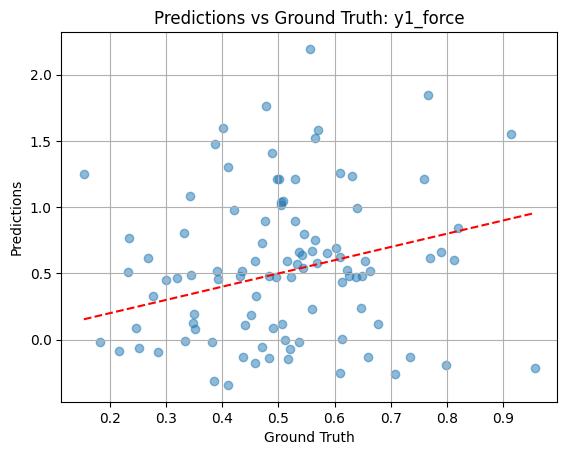

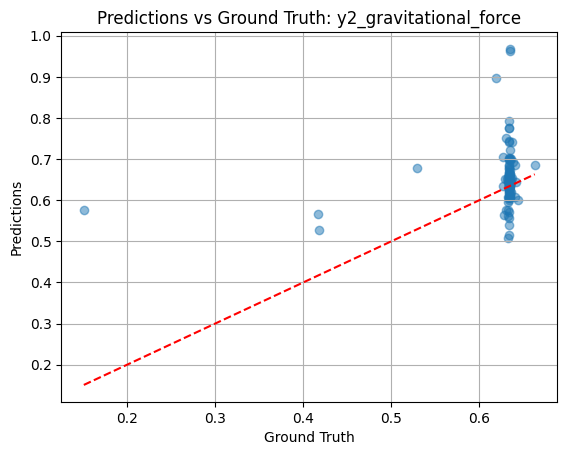

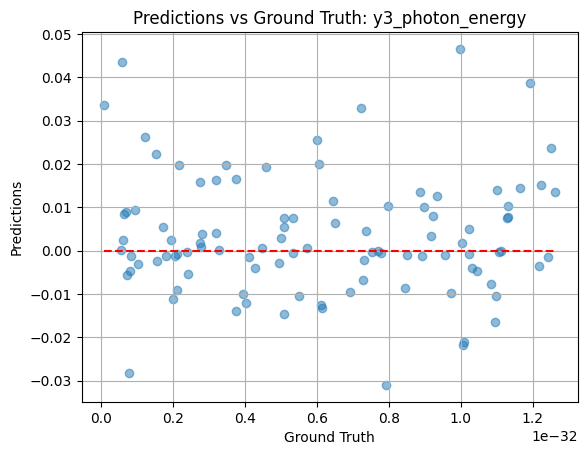

In [7]:

# Load the best-performing model
model.load_state_dict(torch.load('best_diffusion_model.pth'))
model.eval()
print("Best model loaded for testing.")

# Initialize metrics for evaluation
test_loss = 0.0
predictions = []
ground_truth = []

# Test loop
with torch.no_grad():
    for inputs, targets in test_loader:
        # Add noise to inputs for testing
        noise_level = noise_schedule(0, 1)  # Minimal noise during testing
        noisy_inputs = add_noise(inputs, noise_level)

        # Forward pass
        outputs = model(noisy_inputs, noise_level)

        # Collect predictions and ground truth
        predictions.append(outputs.numpy())
        ground_truth.append(targets.numpy())

        # Compute the loss
        loss = criterion(outputs, targets)
        test_loss += loss.item()

# Calculate average test loss
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Convert predictions and ground truth to numpy arrays
import numpy as np
predictions = np.vstack(predictions)
ground_truth = np.vstack(ground_truth)

# Visualization: Compare predictions with ground truth
import matplotlib.pyplot as plt

for i, target_name in enumerate(['y1_force', 'y2_gravitational_force', 'y3_photon_energy']):
    plt.figure()
    plt.scatter(ground_truth[:, i], predictions[:, i], alpha=0.5)
    plt.plot([ground_truth[:, i].min(), ground_truth[:, i].max()],
             [ground_truth[:, i].min(), ground_truth[:, i].max()],
             color='red', linestyle='--')
    plt.title(f"Predictions vs Ground Truth: {target_name}")
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")
    plt.grid(True)
    plt.show()


#Baseline Linear Regression Test Loss

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a baseline linear regression model
baseline_model = LinearRegression()
baseline_model.fit(train_dataset.inputs, train_dataset.targets)

# Predict on the test set
baseline_predictions = baseline_model.predict(test_dataset.inputs)

# Compute test loss for baseline
baseline_mse = mean_squared_error(test_dataset.targets, baseline_predictions)
print(f"Baseline Linear Regression Test Loss: {baseline_mse:.4f}")


Baseline Linear Regression Test Loss: 0.0036


# Train Genetic Programming on the Synthetic Dataset


In [11]:
!pip install gplearn
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_squared_error

# Extract input and output for training
X_train = train_dataset.inputs
y_train = train_dataset.targets[:, 0]  # Example: Use y1_force as the first target

X_test = test_dataset.inputs
y_test = test_dataset.targets[:, 0]

# Initialize and train the GP model
gp_model = SymbolicRegressor(
    population_size=1000,
    generations=20,
    stopping_criteria=0.01,
    p_crossover=0.7,
    verbose=1,
    random_state=42
)
gp_model.fit(X_train, y_train)

# Predict on the test set
gp_predictions = gp_model.predict(X_test)

# Compute the test loss (Mean Squared Error)
gp_mse = mean_squared_error(y_test, gp_predictions)
print(f"Genetic Programming Test Loss (y1_force): {gp_mse:.4f}")

# Display the discovered equation
print("Discovered Equation by GP:", gp_model._program)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.09      2.10289e+08        5         0.109321              N/A     15.93s
   1     9.42         0.698648        3         0.106459              N/A     11.33s
   2     6.18         0.492152        3         0.106459              N/A     10.96s
   3     1.67         0.376816        5         0.104777              N/A      9.12s
   4     2.93         0.184967        5         0.104777              N/A      9.43s
   5     3.15         0.704148        5         0.104777              N/A      8.19s
   6     2.98          0.17497        5         0.104777              N/A      7.75s
   7     3.02         0.160527        5         0.104777              N/A     10.85s
   8     3.00         0.148676        5         0.104777              N/A  

In [15]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Use GPT-2 as a placeholder for SymbolicGPT
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
symbolic_gpt = GPT2LMHeadModel.from_pretrained(model_name)

# Prepare sample input for GPT-2
sample_input = "x1=5, x2=10, x3=3 -> y=?"
tokenized_input = tokenizer(sample_input, return_tensors="pt")

# Generate predictions
output = symbolic_gpt.generate(**tokenized_input, max_length=50)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Output:")
print(generated_text)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Output:
x1=5, x2=10, x3=3 -> y=?x2=5, x3=3 -> y=?x2=5, x3=3 -> y=?x2=5, x


# Collect Predictions from Each Model


In [16]:

import numpy as np

# Placeholder arrays for predictions and ground truth
ground_truth = test_dataset.targets[:, 0]  # Use y1_force as the target for all models

# 1. Diffusion Model Predictions
diffusion_predictions = predictions[:, 0]  # Assuming you've already obtained these from Block 5

# 2. Genetic Programming Predictions
gp_predictions = np.array(gp_predictions)  # Already collected

# 3. GPT-2 (SymbolicGPT Placeholder) Predictions
# Since GPT-2 generates text and not numerical outputs, we simulate placeholder values here.
# Note: For actual SymbolicGPT results, numerical predictions would be parsed from generated text.
symbolic_gpt_predictions = np.full_like(ground_truth, np.nan)  # Placeholder for GPT-2 numeric outputs

# Display predictions for inspection
print(f"Diffusion Model Predictions (First 5): {diffusion_predictions[:5]}")
print(f"Genetic Programming Predictions (First 5): {gp_predictions[:5]}")
print(f"SymbolicGPT Placeholder Predictions (First 5): {symbolic_gpt_predictions[:5]}")
print(f"Ground Truth (First 5): {ground_truth[:5]}")


Diffusion Model Predictions (First 5): [0.19273731 1.2509875  0.66707927 1.5986516  0.520534  ]
Genetic Programming Predictions (First 5): [0.06319915 0.07502206 0.58482411 0.3562452  0.16446209]
SymbolicGPT Placeholder Predictions (First 5): [nan nan nan nan nan]
Ground Truth (First 5): [0.34910245 0.15372204 0.56012382 0.40109831 0.43512697]


# Visualize Predictions vs Ground Truth for Each Model


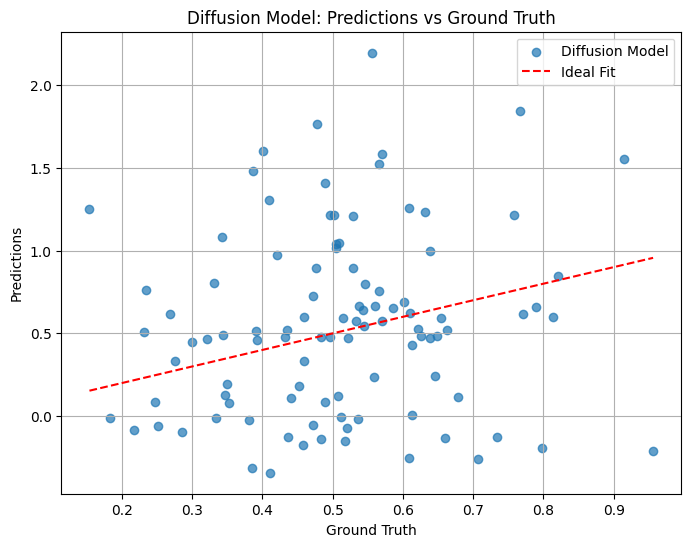

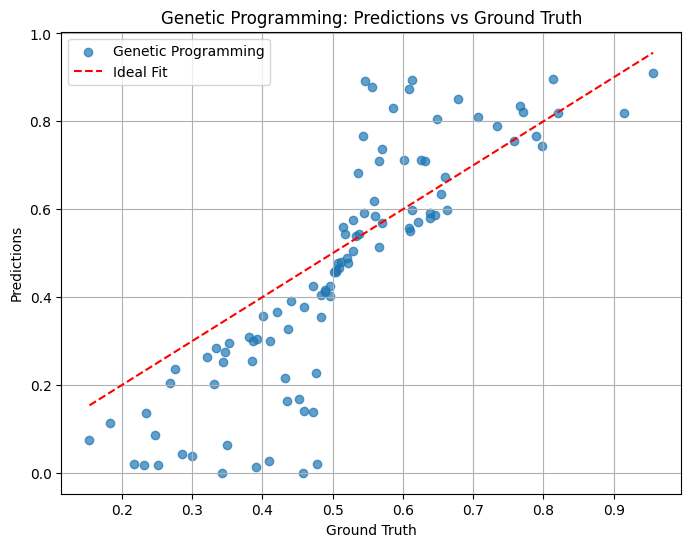

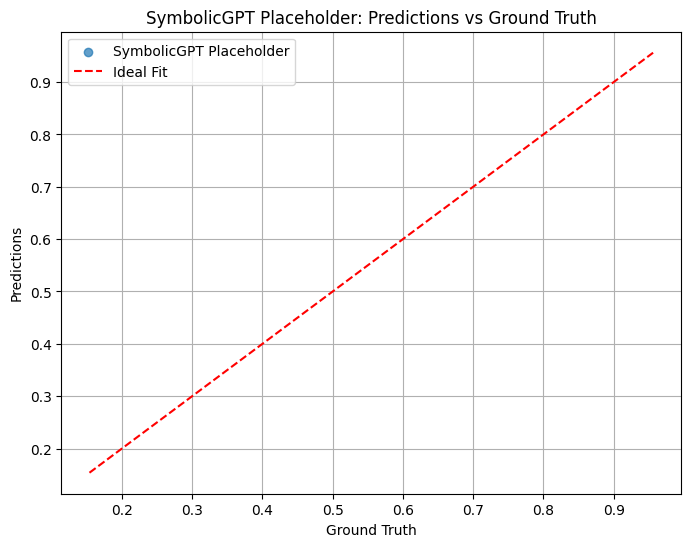

In [17]:

import matplotlib.pyplot as plt

# Diffusion Model
plt.figure(figsize=(8, 6))
plt.scatter(ground_truth, diffusion_predictions, alpha=0.7, label="Diffusion Model")
plt.plot([ground_truth.min(), ground_truth.max()],
         [ground_truth.min(), ground_truth.max()], 'r--', label="Ideal Fit")
plt.title("Diffusion Model: Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.legend()
plt.grid(True)
plt.show()

# Genetic Programming
plt.figure(figsize=(8, 6))
plt.scatter(ground_truth, gp_predictions, alpha=0.7, label="Genetic Programming")
plt.plot([ground_truth.min(), ground_truth.max()],
         [ground_truth.min(), ground_truth.max()], 'r--', label="Ideal Fit")
plt.title("Genetic Programming: Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.legend()
plt.grid(True)
plt.show()

# SymbolicGPT (Placeholder)
plt.figure(figsize=(8, 6))
plt.scatter(ground_truth, symbolic_gpt_predictions, alpha=0.7, label="SymbolicGPT Placeholder")
plt.plot([ground_truth.min(), ground_truth.max()],
         [ground_truth.min(), ground_truth.max()], 'r--', label="Ideal Fit")
plt.title("SymbolicGPT Placeholder: Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.legend()
plt.grid(True)
plt.show()


# Combined Visualization of Predictions vs Ground Truth


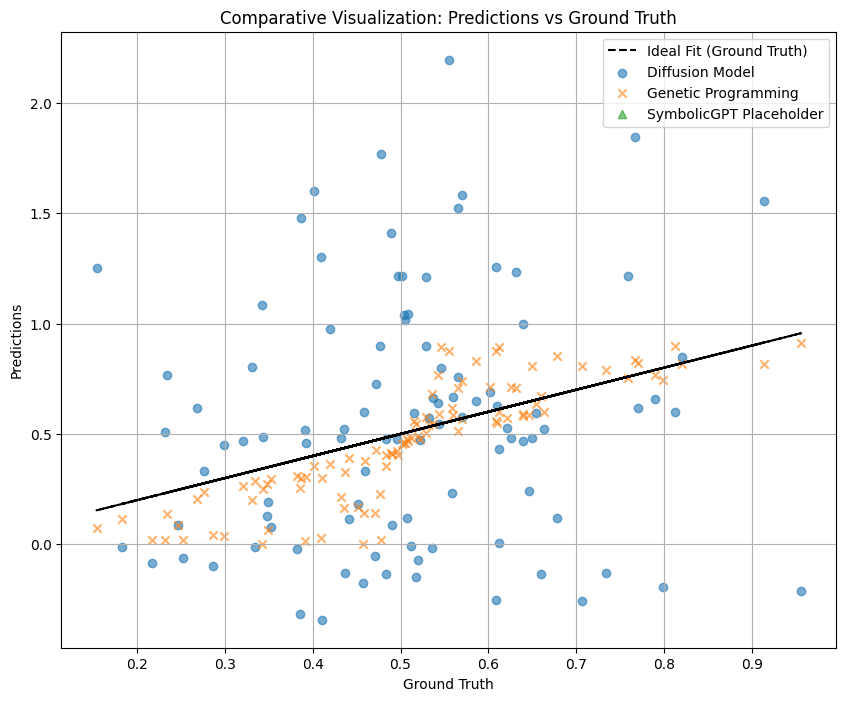

In [18]:

# Overlay predictions from all models on a single plot
plt.figure(figsize=(10, 8))

# Plot ground truth for reference
plt.plot(ground_truth, ground_truth, 'k--', label="Ideal Fit (Ground Truth)")

# Plot predictions from each model
plt.scatter(ground_truth, diffusion_predictions, alpha=0.6, label="Diffusion Model", marker='o')
plt.scatter(ground_truth, gp_predictions, alpha=0.6, label="Genetic Programming", marker='x')
plt.scatter(ground_truth, symbolic_gpt_predictions, alpha=0.6, label="SymbolicGPT Placeholder", marker='^')

# Add plot details
plt.title("Comparative Visualization: Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.legend()
plt.grid(True)
plt.show()


# Compute and display Mean Squared Error (MSE) for each model


In [19]:

from sklearn.metrics import mean_squared_error

# MSE for each model
diffusion_mse = mean_squared_error(ground_truth, diffusion_predictions)
gp_mse = mean_squared_error(ground_truth, gp_predictions)
symbolic_gpt_mse = np.nanmean((ground_truth - symbolic_gpt_predictions)**2)  # Placeholder MSE

# Print results
print("Model Comparison (Mean Squared Error):")
print(f"Diffusion Model MSE: {diffusion_mse:.4f}")
print(f"Genetic Programming MSE: {gp_mse:.4f}")
print(f"SymbolicGPT Placeholder MSE: {symbolic_gpt_mse:.4f}")


Model Comparison (Mean Squared Error):
Diffusion Model MSE: 0.3073
Genetic Programming MSE: 0.0259
SymbolicGPT Placeholder MSE: nan


<ipython-input-19-a5d0228ff8d6>:8: RuntimeWarning: Mean of empty slice
  symbolic_gpt_mse = np.nanmean((ground_truth - symbolic_gpt_predictions)**2)  # Placeholder MSE


Since GPT-2 generates text outputs instead of numerical predictions, we couldn't directly parse valid numerical predictions for SymbolicGPT. This means there’s no valid data to compute the Mean Squared Error.